# Max Regression

A demo of the toy max-regression problem from the paper.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

import settransformer as stf

## Model

This model learns to approximate the largest number in the given set of numbers, regardless of the order presented.

In [6]:
class MaxRegressionSetTransformer(keras.models.Model):
    def __init__(self, use_keras_mha=False, layernorm=False):
        super(MaxRegressionSetTransformer, self).__init__()
        
        # Encoder
        inp = keras.layers.Input((None, 1))
        out = keras.layers.Dense(64)(inp)
        # out = stf.SetAttentionBlock(64, 4)(out)
        # out = stf.SetAttentionBlock(64, 4)(out)
        out = stf.SetAttentionBlock(64, 4, use_keras_mha=use_keras_mha, layernorm=layernorm)(out)
        out = stf.SetAttentionBlock(64, 4, use_keras_mha=use_keras_mha, layernorm=layernorm)(out)
        self.encoder = keras.models.Model(inp, out)
        
        # Decoder
        inp = keras.layers.Input((None, 64))
        out = stf.PoolingByMultiHeadAttention(1, 64, 1, use_keras_mha=use_keras_mha, layernorm=layernorm)(inp)
        # out = stf.PoolingByMultiHeadAttention(1, 64, 1)(inp)
        out = keras.layers.Dense(1)(out)
        self.decoder = keras.models.Model(inp, out)
        
    def call(self, x):
        return tf.squeeze(self.decoder(self.encoder(x)))

---
## Data Generation

The following function generates a batch sets, each consisting of *length* numbers.

In [7]:
def gen_data(batch_size, length=5):
    x = np.random.randint(1, 100, (batch_size, length))
    y = np.max(x, axis=1)
    x, y = np.expand_dims(x, axis=2), np.expand_dims(y, axis=1)
    return x, y # (batch_size, length, 1) (each number is a 1-element set)

In [8]:
x, y = gen_data(3, 5)

In [9]:
x.shape

(3, 5, 1)

In [10]:
x[:2]

array([[[84],
        [ 4],
        [14],
        [81],
        [35]],

       [[44],
        [ 5],
        [69],
        [19],
        [28]]])

In [11]:
y.shape

(3, 1)

In [12]:
y[:2]

array([[84],
       [69]])

---
## Training

In [13]:
model = MaxRegressionSetTransformer()
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=keras.losses.MeanAbsoluteError())

2022-04-23 01:59:59.722173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 01:59:59.722992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 01:59:59.728111: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 01:59:59.729482: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 01:59:59.730900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [14]:
model(x[:2]), x[:2]

2022-04-23 02:00:01.385693: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([49.1132  , 36.465218], dtype=float32)>,
 array([[[84],
         [ 4],
         [14],
         [81],
         [35]],
 
        [[44],
         [ 5],
         [69],
         [19],
         [28]]]))

In [15]:
x, y = gen_data(batch_size=2 ** 10, length=5)

In [16]:
history = model.fit(x, y, epochs=500, verbose=0)

2022-04-23 02:00:08.717365: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


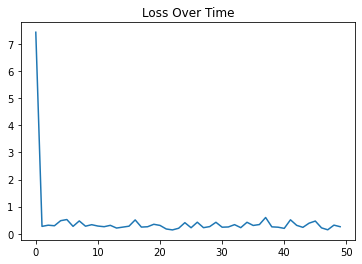

In [17]:
plt.plot(history.history["loss"][::10])
plt.title("Loss Over Time")
plt.show()